<IPython.core.display.Javascript object>


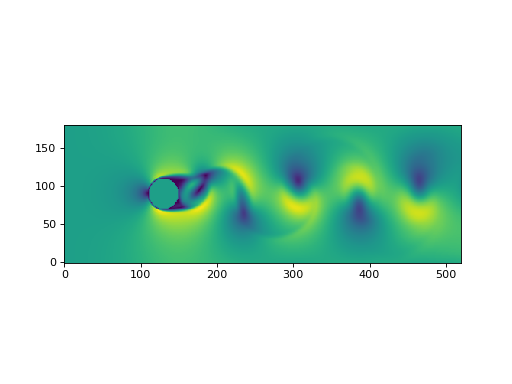

In [3]:
import matplotlib.animation as animation
from numpy import *; from numpy.linalg import *
import matplotlib.pyplot as plt; from matplotlib import cm
###### Flow definition #########################################################
maxIter = 50000 # Total number of time iterations.
Re      = 220.0  # Reynolds number.
nx = 520; ny = 180; ly=ny-1.0; q = 9 # Lattice dimensions and populations.
cx = nx/4; cy=ny/2; r=ny/9;          # Coordinates of the cylinder.
uLB     = 0.04                       # Velocity in lattice units.
nulb    = uLB*r/Re; omega = 1.0 / (3.*nulb+0.5); # Relaxation parameter.

###### Lattice Constants #######################################################
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) # Lattice velocities.
t = 1./36. * ones(q)                                   # Lattice weights.
t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.; t[0] = 4./9.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 
i1 = arange(q)[asarray([ci[0]<0  for ci in c])] # Unknown on right wall.
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] # Vertical middle.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] # Unknown on left wall.

###### Function Definitions ####################################################
sumpop = lambda fin: sum(fin,axis=0) # Helper function for density computation.
def equilibrium(rho,u):              # Equilibrium distribution function.
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

###### Setup: cylindrical obstacle and velocity inlet with perturbation ########
obstacle = fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<r**2, (nx,ny))
vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
feq = equilibrium(1.0,vel); fin = feq.copy()

###### Main time loop ##########################################################
images = []
%matplotlib notebook
fig = plt.figure()

for time in range(maxIter):
    fin[i1,-1,:] = fin[i1,-2,:] # Right wall: outflow condition.
    rho = sumpop(fin)           # Calculate macroscopic density and velocity.
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho

    u[:,0,:] =vel[:,0,:] # Left wall: compute density from known populations.
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))

    feq = equilibrium(rho,u) # Left wall: Zou/He boundary condition.
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    fout = fin - omega * (fin - feq)  # Collision step.
    for i in range(q): fout[i,obstacle] = fin[noslip[i],obstacle]
    for i in range(q): # Streaming step.
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
 
    if (time%100==0): # Visualization
        #plt.clf(); 
        imm = plt.imshow(sqrt(u[0]**2+u[1]**2).T,origin='lower',animated =True)
        #print('ha')
        images.append([imm])
        #plt.savefig("vel."+str(time/100).zfill(4)+".png")
anim = animation.ArtistAnimation(fig,images,interval = 30, repeat=False)
anim.save('attempt.mp4')